# Catboost Experiments

## Experiments

Each "experiment" consists in a set of identical models, trained on different folds of data (with both consistent model and features parameters).

(Reason: The metrics for each model tend to vary a little, so training them on many folds enables a more accurate comparison across models/features)

## Metrics

The main metrics tracked are:
- Biased MAE (from [#9](https://github.com/related-sciences/nxontology-ml/issues/9))
- The class "Biases" (also [#9](https://github.com/related-sciences/nxontology-ml/issues/9)) are:
```python
biases = {
    "01-disease-subtype": 0.25,
    "02-disease-root": 0.25,
    "03-disease-area": 0.5,
}
```
- For both training and cv sets: ROC, F1 & model Loss ([CatBoost's `MultiClass`](https://catboost.ai/en/docs/concepts/loss-functions-multiclassification))

## Parameters

Constant parameters across each experiment (currently):
- Shuffled inputs
- 25 folds stratified CV
- Best model is selected (based on BiasedMAE)
- 5000 training iterations
- Learning rate of 0.5

# Loading Experiments Data

In [1]:
%load_ext autoreload
%autoreload 2

from experimentation.metadata_helpers import (
    df_from_all_experiments,
    NUMERICAL_COLUMNS,
    EXPERIMENT_MODEL_DIR,
)
from typing import List
import pandas as pd
import seaborn as sns

sns.set_theme()

In [2]:
df = df_from_all_experiments()

# Sort by median BiasedMAE
experiment_median_mae = df.groupby("experiment_name")["biased_mae"].median().to_dict()
df = df.sort_values(
    by="experiment_name", key=lambda e: e.apply(experiment_median_mae.get)
)

# Experiments by Biased MAEs

In [3]:
import warnings

# Since updating Pandas, seaborn is throwing a lot of pandas FutureWarning :(
warnings.simplefilter(action="ignore", category=FutureWarning)

<Axes: xlabel='biased_mae', ylabel='experiment_name'>

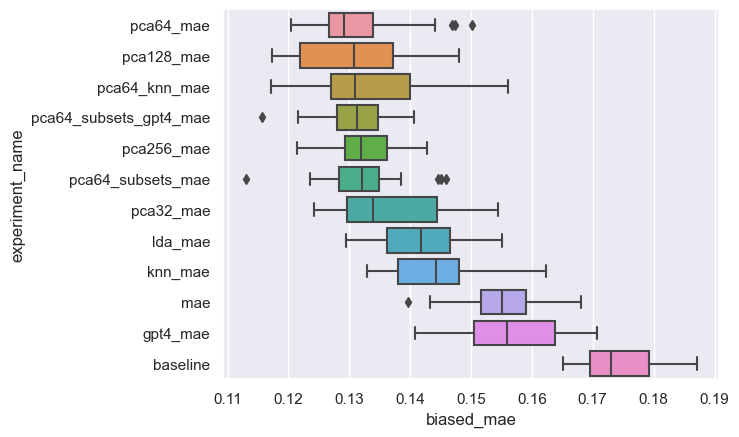

In [4]:
sns.boxplot(data=df, x="biased_mae", y="experiment_name")

Notes about experiments:
- `baseline`: (Mostly) default parameters for network only features (as presented in [#7](https://github.com/related-sciences/nxontology-ml/pull/7))
- `mae`: Uses the (custom coded) `BiasedMAE` metric as [CatBoost's custom `eval_metric`](https://catboost.ai/en/docs/concepts/python-usages-examples#custom-loss-function-eval-metric)
- `d7`: CatBoost tree depth of 7 (default is 6) - although not obvious here, `d=7` usually helps when using more features
- `knn`: Use Faiss NN tree proximity features
- `lda`: 3 Class LDA for dimensionality reduction
- `pcaX`: PCA of `X` components for dimensionality reduction

For MAE comparison: 
- A random classifier with real class weights prior has a biased MAE of `0.340`
- A random classifier with uniform class weights prior has a biased MAE of `0.426`

# Top experiment (`pca128_d7_mae`) analysis

## CatBoost's `MetricVisualizer`

In [5]:
import catboost

experiment_dir = EXPERIMENT_MODEL_DIR / "20230908_031209_pca64_mae"
w = catboost.MetricVisualizer(experiment_dir.as_posix(), subdirs=True)
w.start()

# Notes:
# - This visualization runs JavaScript and won't be displayed on the web
# - The experiment data is needed locally for this code to render

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

# Metrics Cross-Analysis

/Users/romain/dev/nxontology-ml/.venv/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


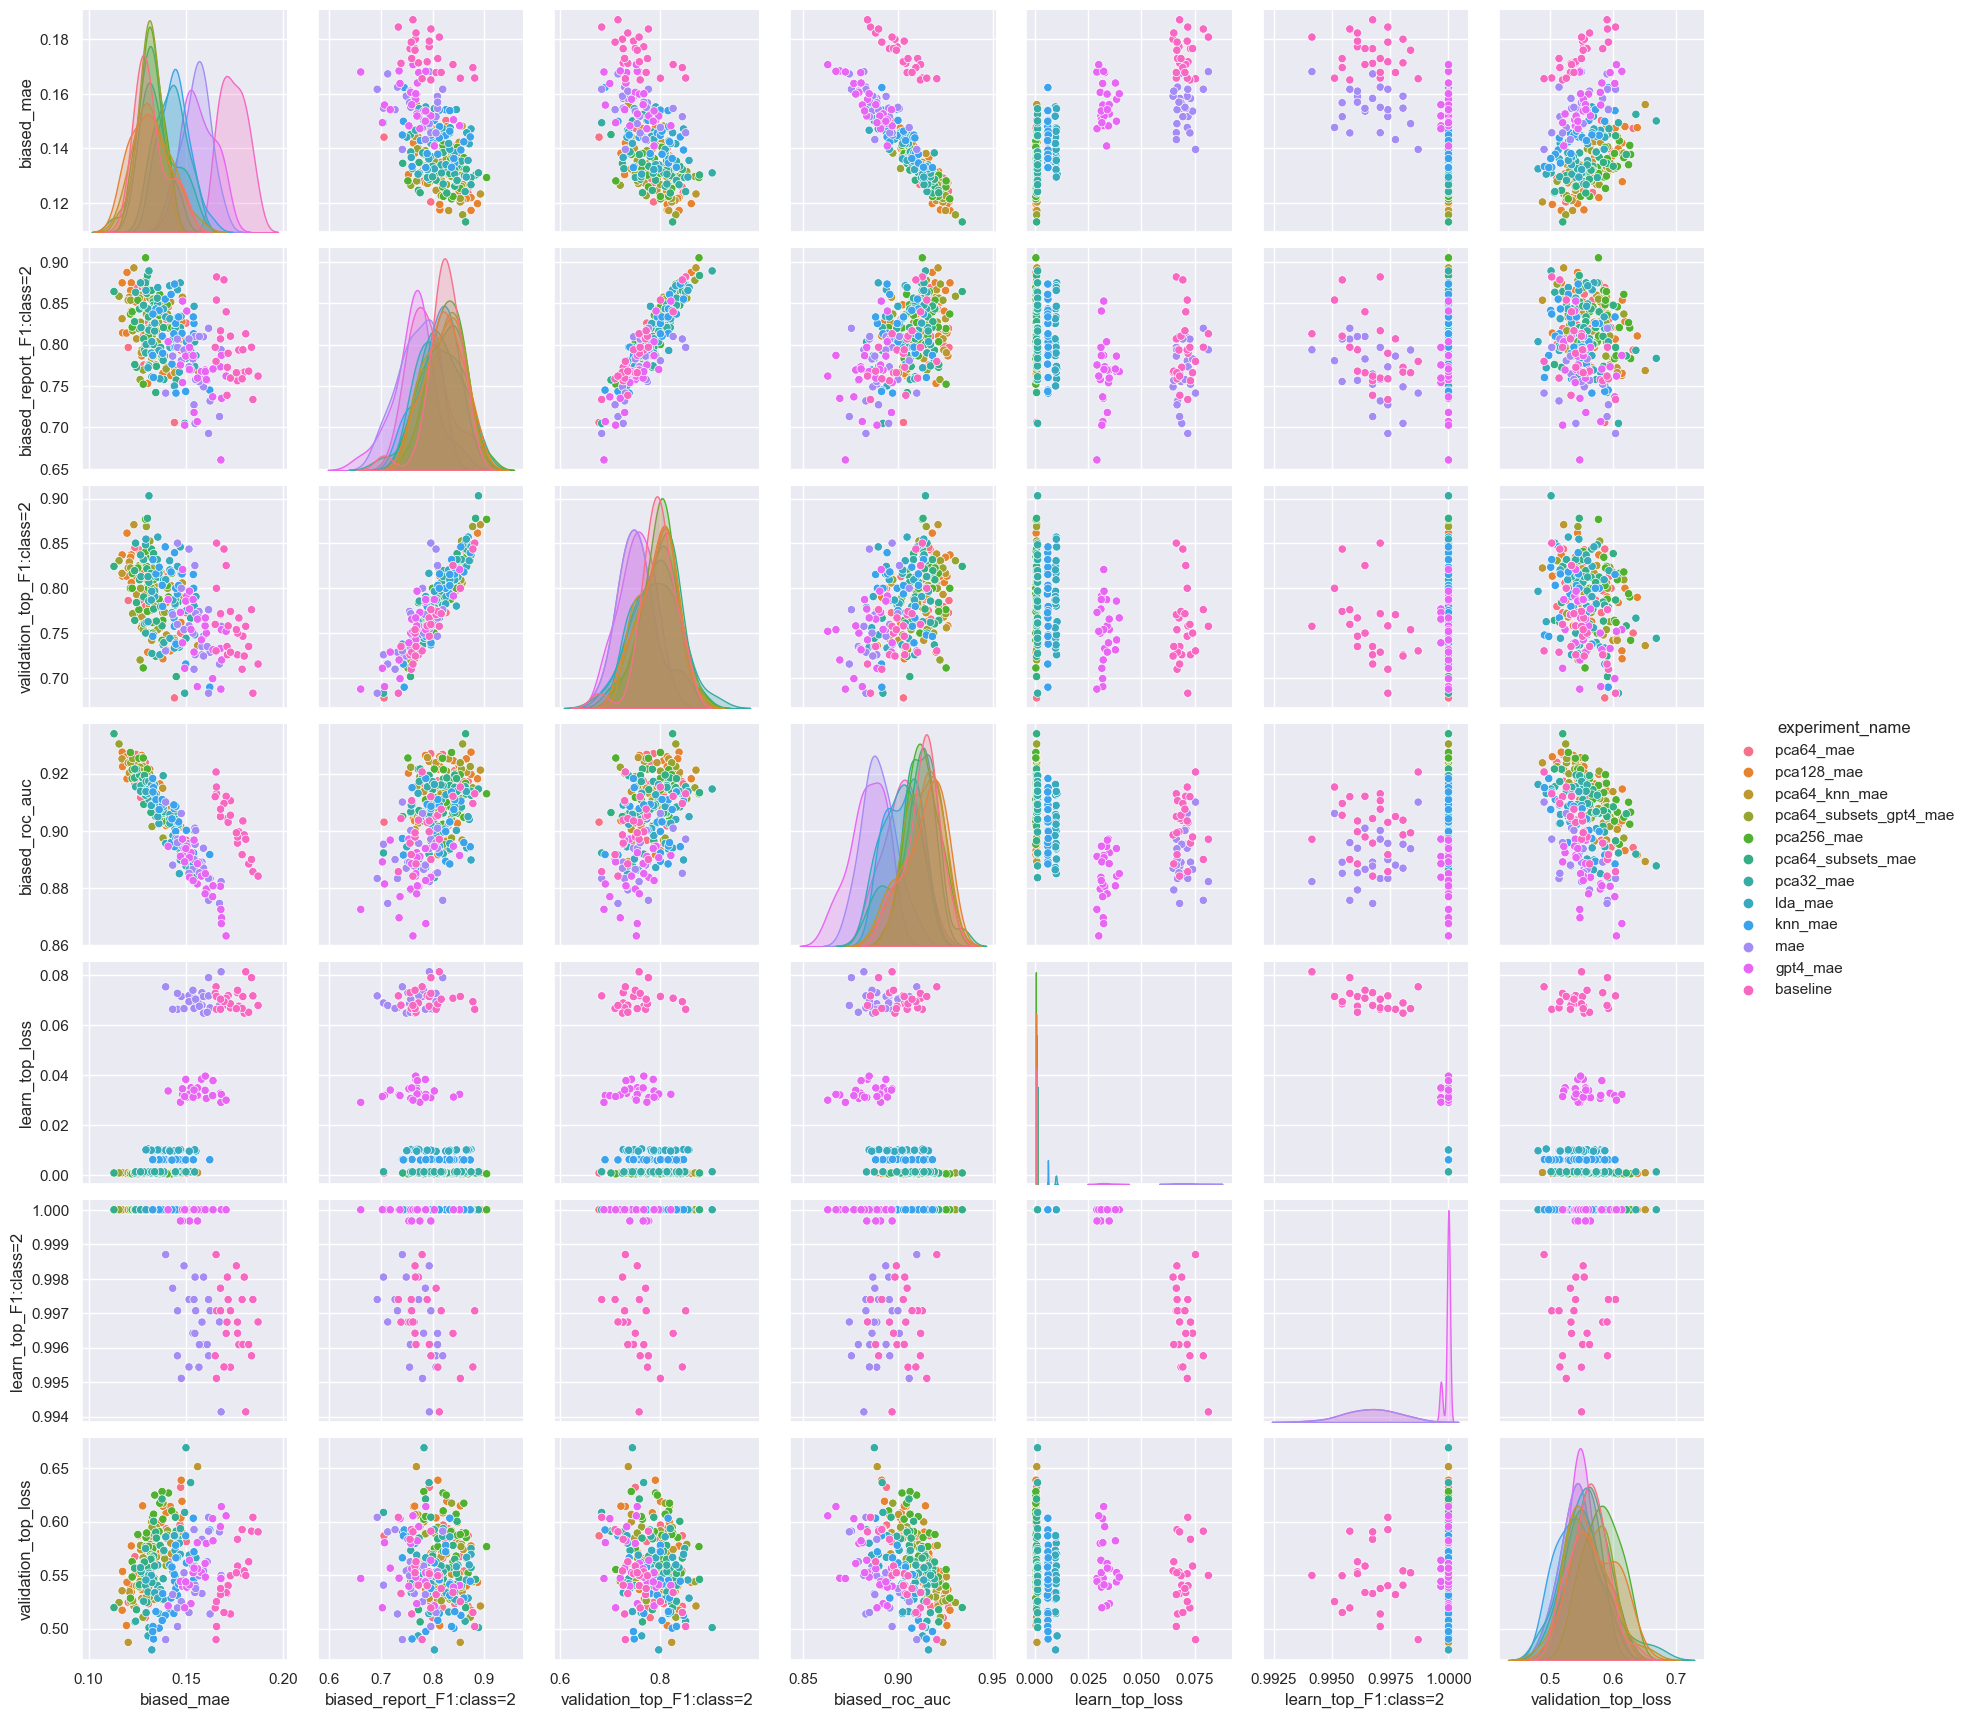

In [6]:
excluded_columns = {
    "roc_auc",  # Correlation with biased_roc_auc
    "validation_top_AUC:type=Mu",  # Correlation with biased_roc_auc
    "report_F1:class=2",  # Correlation with biased_report_F1:class=2
    "mae",  # Correlation with biased_mae
}
columns = list({"experiment_name"} | (set(NUMERICAL_COLUMNS) - excluded_columns))
sns.pairplot(df[columns], hue="experiment_name")

Notes:
- `learn_`: Computed by Catboost during training
- `validation_`: Computed by Catboost during CV
- `report_`: From SKLearn's Classifier report

# Experiment Training Durations

In [7]:
df.head()

,experiment_name,experiment_description,fold,start_time,report_F1:class=2,biased_report_F1:class=2,roc_auc,biased_roc_auc,mae,biased_mae,learn_loss,learn_top_loss,learn_top_F1:class=2,validation_top_loss,validation_top_AUC:type=Mu,validation_top_F1:class=2,tree_cnt,feature_building_d,training_d,eval_d
100,pca64_mae,pca64_mae,4,2023-09-08 03:12:09.701725,0.834646,0.868852,0.911262,0.916537,0.189135,0.125544,MultiClass,0.000910,1.0,0.586807,0.942226,0.843750,5000,0 days 00:00:09.916012,0 days 00:01:52.526413,0 days 00:00:00.028736
124,pca64_mae,pca64_mae,23,2023-09-08 03:12:09.701725,0.796610,0.820961,0.908549,0.911640,0.185136,0.126710,MultiClass,0.000912,1.0,0.557032,0.941519,0.796610,5000,0 days 00:00:09.779286,0 days 00:01:44.433804,0 days 00:00:00.040361
123,pca64_mae,pca64_mae,24,2023-09-08 03:12:09.701725,0.790323,0.827004,0.906635,0.911752,0.188567,0.130630,MultiClass,0.000879,1.0,0.569308,0.938458,0.800000,5000,0 days 00:00:10.207409,0 days 00:01:52.554551,0 days 00:00:00.036943
122,pca64_mae,pca64_mae,12,2023-09-08 03:12:09.701725,0.661017,0.705882,0.902076,0.902993,0.195146,0.144089,MultiClass,0.000906,1.0,0.586675,0.931863,0.677686,4251,0 days 00:00:10.032442,0 days 00:02:01.429357,0 days 00:00:00.040998
121,pca64_mae,pca64_mae,15,2023-09-08 03:12:09.701725,0.796748,0.830508,0.897729,0.901708,0.206339,0.139849,MultiClass,0.000879,1.0,0.593307,0.935162,0.813008,5000,0 days 00:00:10.644857,0 days 00:01:37.757880,0 days 00:00:00.032910


/Users/romain/dev/nxontology-ml/.venv/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


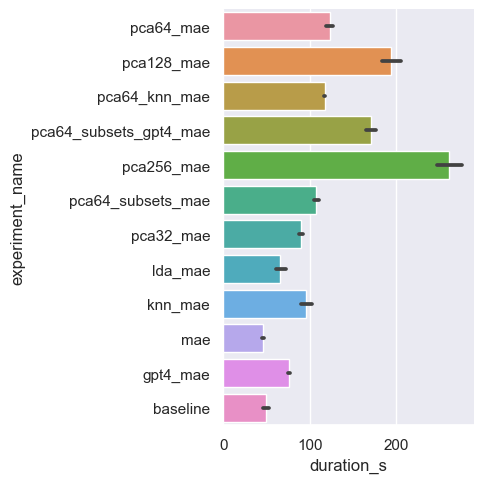

In [8]:
df["duration_s"] = (df["feature_building_d"] + df["training_d"]).dt.total_seconds()
sns.catplot(data=df, kind="bar", x="duration_s", y="experiment_name")

Notes:
- These duration are in seconds, per fold

# Experiment number of iterations

/Users/romain/dev/nxontology-ml/.venv/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


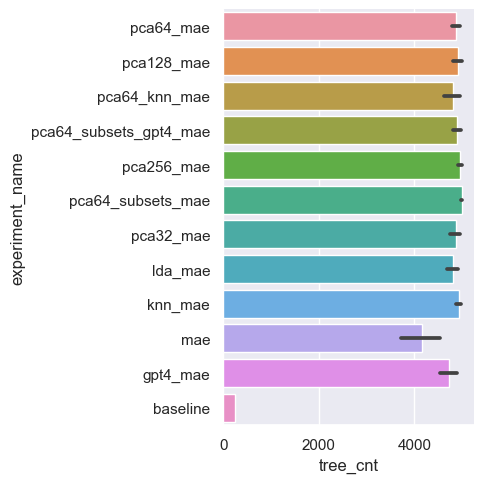

In [9]:
sns.catplot(
    data=df,
    x="tree_cnt",
    y="experiment_name",
    kind="bar",
)

Notes:
- For the models nearing `5000`, a little more performance could be gained by raising the number of max iterations

# MAE Baselines

In [10]:
import numpy as np
from experimentation.model_utils import CLASS_WEIGHTS, mean_absolute_error


def mae_baseline(class_weights: np.ndarray) -> float:
    biased_mae = 0
    for i, w_i in enumerate(CLASS_WEIGHTS):
        for j, w_j in enumerate(class_weights):
            y_true = np.zeros(len(CLASS_WEIGHTS))
            y_true[i] = 1
            y = np.zeros(len(CLASS_WEIGHTS))
            y[j] = 1
            biased_mae += (
                w_i * w_j * mean_absolute_error(np.array([y_true]), np.array([y]))
            )  # Biased by default
    return biased_mae


print(f"Baseline MAE (with weighted class prior): {mae_baseline(CLASS_WEIGHTS):.3f}")
print(
    f"Baseline MAE (with uniform class prior): {mae_baseline(np.array([1/3, 1/3, 1/3])):.3f}"
)

Baseline MAE (with weighted class prior): 0.340
Baseline MAE (with uniform class prior): 0.426


In [11]:
# Empirical check
N = 100000
print(
    mean_absolute_error(
        y_true=np.array([np.random.multinomial(1, CLASS_WEIGHTS) for _ in range(N)]),
        y_probas=np.array([np.random.multinomial(1, CLASS_WEIGHTS) for _ in range(N)]),
    )
)

0.339975


# Some Conclusions (mostly from past experiments)
* Having a custom eval metric is very important
* More iterations is good
* LR declines over 1 (Sweet spot ~.5) - TODO: Add proof
* GPUs do not support custom eval
* Adding weights to samples does not help - TODO: Add proof
* (Depth helps but makes training slower - TODO: Add better proof)

# Possible Next steps
* Add GPT 4 label to features
* Node error analysis:
  1. Find nodes where the biggest mistakes are made 
  2. Try to come up with pattern in data (& features)
  3. Craft useful features if possible
* (Add feature importances to this report?)